In [2]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
# 2. Đọc file csv và gắn index
df = pd.read_csv('/content/drive/MyDrive/Third Year/Sem 2/Business Data Analyst/dataset/Palladium.csv')
df = df.reset_index()['Close']
df

0        995.5
1       1007.5
2        984.0
3        992.5
4        992.5
         ...  
1682    1535.0
1683    1514.5
1684    1535.5
1685    1549.5
1686    1551.5
Name: Close, Length: 1687, dtype: float64

In [4]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data = (X_test, ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
20/20 [==============================] - 12s 253ms/step - loss: 0.0602 - val_loss: 0.0034
Epoch 2/100
20/20 [==============================] - 3s 172ms/step - loss: 0.0070 - val_loss: 0.0048
Epoch 3/100
20/20 [==============================] - 4s 206ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 4/100
20/20 [==============================] - 5s 239ms/step - loss: 0.0029 - val_loss: 8.1001e-04
Epoch 5/100
20/20 [==============================] - 3s 171ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 6/100
20/20 [==============================] - 3s 172ms/step - loss: 0.0026 - val_loss: 9.6445e-04
Epoch 7/100
20/20 [==============================] - 4s 224ms/step - loss: 0.0026 - val_loss: 9.1057e-04
Epoch 8/100
20/20 [==============================] - 5s 229ms/step - loss: 0.0026 - val_loss: 8.0984e-04
Epoch 9/100
20/20 [==============================] - 3s 174ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 10/100
20/20 [==============================] - 3s 174ms/step - loss

In [11]:
# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

8/8 [==============================] - 4s 99ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [13]:
train_size1 = int(0.8 * len(df))
test_size1 = len(df) - train_size

train_data1 = df[:train_size]
test_data1 = df[train_size:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

In [14]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Testing MAE:', test_mae)

Testing RMSE: 446.95715627149985
Testing MAPE: 16.37308648116134
Testing MAE: 318.7857480500934


In [15]:
# 13. Dự báo 30 ngày tiếp theo
from numpy import array
lst_output = []
n_steps = 66
i = 0

x_input = test_data[len(test_data) - n_steps:].reshape(1,-1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

while(i<30):

    if(len(temp_input)>66):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.29198882]
67
1 day input [0.20961829 0.20681475 0.20012939 0.21565667 0.21565667 0.18826828
 0.1986198  0.20293293 0.20703041 0.22169506 0.22169506 0.21457839
 0.21371576 0.22881173 0.2214794  0.26202286 0.26202286 0.26202286
 0.24045719 0.24153548 0.22989002 0.22816476 0.24282942 0.24369204
 0.23485012 0.21263748 0.21759758 0.22191072 0.22191072 0.21932284
 0.22881173 0.22902739 0.22708648 0.22126375 0.22126375 0.21953849
 0.23635972 0.24692689 0.24282942 0.22320466 0.22708648 0.21587233
 0.25318094 0.29544964 0.31054561 0.30472288 0.30493854 0.32391633
 0.32111279 0.31852491 0.31205521 0.30278197 0.30321328 0.30127237
 0.30127237 0.2941557  0.29394005 0.2827259  0.28380418 0.28747035
 0.29135217 0.28251024 0.29156782 0.29760621 0.29846884 0.29198882]
1 day output [[0.29062542]]
2 day input [0.20681475 0.20012939 0.21565667 0.21565667 0.18826828 0.1986198
 0.20293293 0.20703041 0.22169506 0.22169506 0.21457839 0.21371576
 0.22881173 0.2214794  0.26202286 0.26202286 0.26202286 0.240

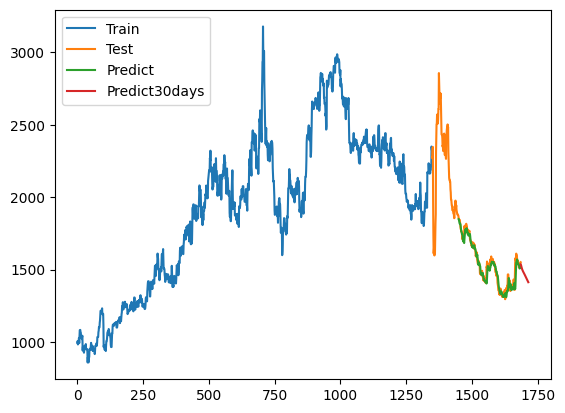

<Figure size 1600x900 with 0 Axes>

In [16]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.figure(figsize=(16,9))
plt.show()